# Soft-sensing with linear models [2]
# 2. Multivariate case

In [the previous post](Soft-Sensing1.ipynb), I showed that linear regression (LR) and probabilistic principal component analysis (PPCA), when used as a soft-senor, deliver exactly the same predictions. This is however only true when the number of components in the PPCA model ($K$) is equal to or just one less that the number of measured variables ($N$), i.e. when $K=N-1$ or $K=N$. In this post, I am using the same soft-sensors again, but now in a multivariate case where LR and PPCA deliver different predictions. The notebook used to create this post is available on [GitLab](https://gitlab.com/krisvillez/software-sensors).

## 2.1. Toy example

We use a simulated example of spectral measurements. The spectral measurements are used to predict a target concentration of a light-absorbing component. Both the spectra and the component concentration measurements are subject to measurement error and are available for model identification. The next figure shows two spectra with and without measurement errors. Each spectrum contains $N=51$ absorbance measurements. Note that the measurement errors are relatively large for demonstration purposes.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
from scipy.stats import norm
from scipy.stats import pearsonr

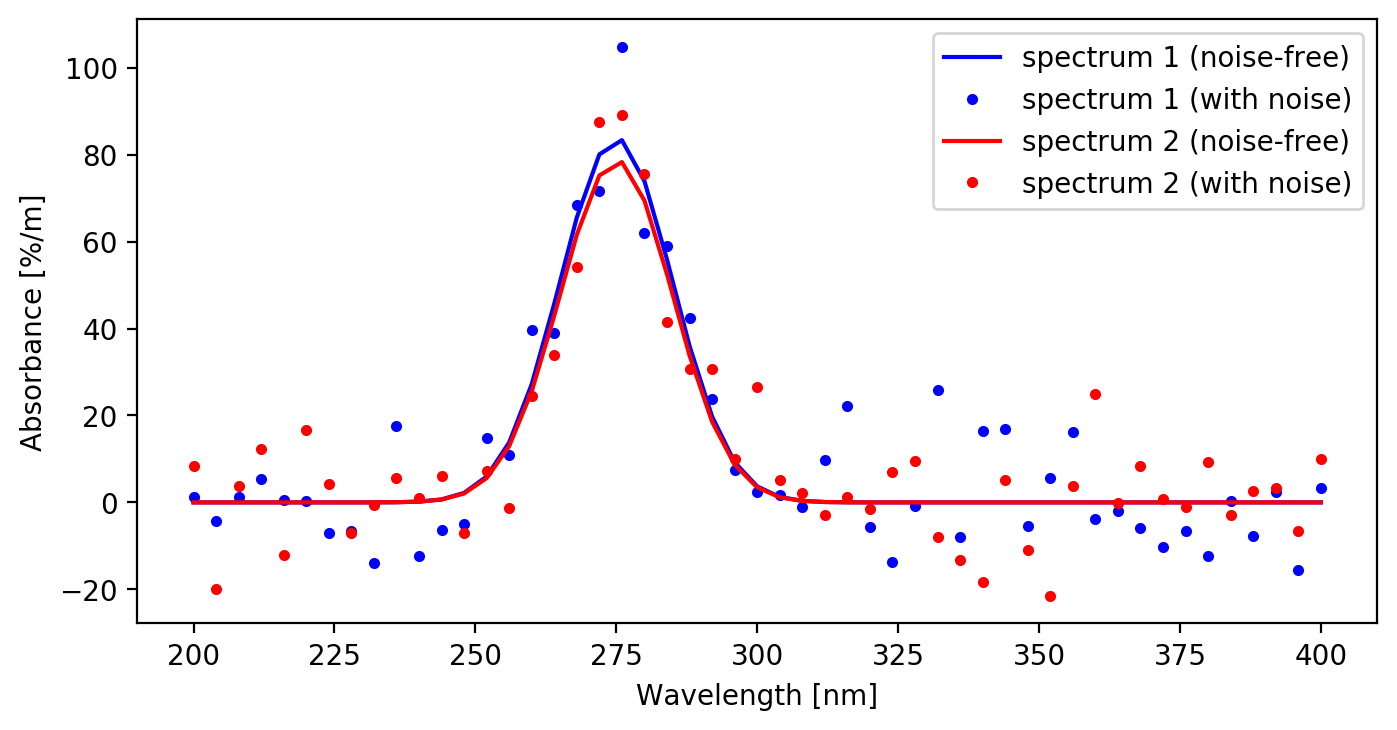

In [2]:
np.random.seed(42)

M_cal = 200
M_test = 1000
s0 = 20 
y_cal = s0*np.random.normal(0, 1, M_cal)+200
y_test = s0*np.random.normal(0, 1, M_test)+200

sigme_e = 10 # measurement error standard deviation, same across all inputs and outputs
K=1

L = 51
x = np.linspace(200,400,L)
spectrum = norm.pdf((x-275)/10)

X_cal = np.dot(y_cal[:,None],spectrum[None,:])
Xtil_cal = X_cal+np.random.normal(0, sigme_e, np.shape(X_cal))
ytil_cal = y_cal+np.random.normal(0, sigme_e, np.shape(y_cal))


X_test = np.dot(y_test[:,None],spectrum[None,:])
Xtil_test = X_test+np.random.normal(0, sigme_e, np.shape(X_test))
ytil_test = y_test+np.random.normal(0, sigme_e, np.shape(y_test))


fig,axs = plt.subplots(nrows=1, ncols=1,figsize=[8,4],dpi=200, sharex='col', sharey='row') 
ax = axs #[0,0]
ax.plot(x, X_cal[0,:].T,'b-',label='spectrum 1 (noise-free)')
ax.plot(x, Xtil_cal[0,:].T,'b.',label='spectrum 1 (with noise)')
ax.plot(x, X_cal[1,:].T,'r-',label='spectrum 2 (noise-free)')
ax.plot(x, Xtil_cal[1,:].T,'r.',label='spectrum 2 (with noise)')
ax.set_xlabel('Wavelength [nm]' )
ax.set_ylabel('Absorbance [%/m]' )
ax.legend();


## 2.2. Model identification and use


### 2.2.1. Model Calibration

The same three models and imputation methods are used as in the previous post:

* LR: Linear regression

* PCA: Principal component analysis with projection to the model plane (PMP)

* PPCA: Probabilistic principal component analysis with maximum likelihood imputation

As before, we assume to know the true number of principal components, which is $K=1$, while the number of variables is much larger ($N=51$). 

The next plot shows the regression coefficients as a function of wavelength, in addition to a reference model obtained with noise-free data. Each model provides a noisy approximation of the ideal regression coefficients. However, the LR coefficients appear noisier than the PCA and PPCA regression coefficients. One can also see that the PPCA regression coefficients tend to be smaller than the ones obtained with PCA. This can be interpreted as a regularizing effect of using the PPCA model as a Bayesian prior for new model inputs.

In [3]:
# relationship between true variables
X    = np.concatenate([np.ones(M_cal)[:,None],X_cal],axis=1)
Xbar = np.linalg.pinv(X)
beta = np.dot(Xbar,y_cal)

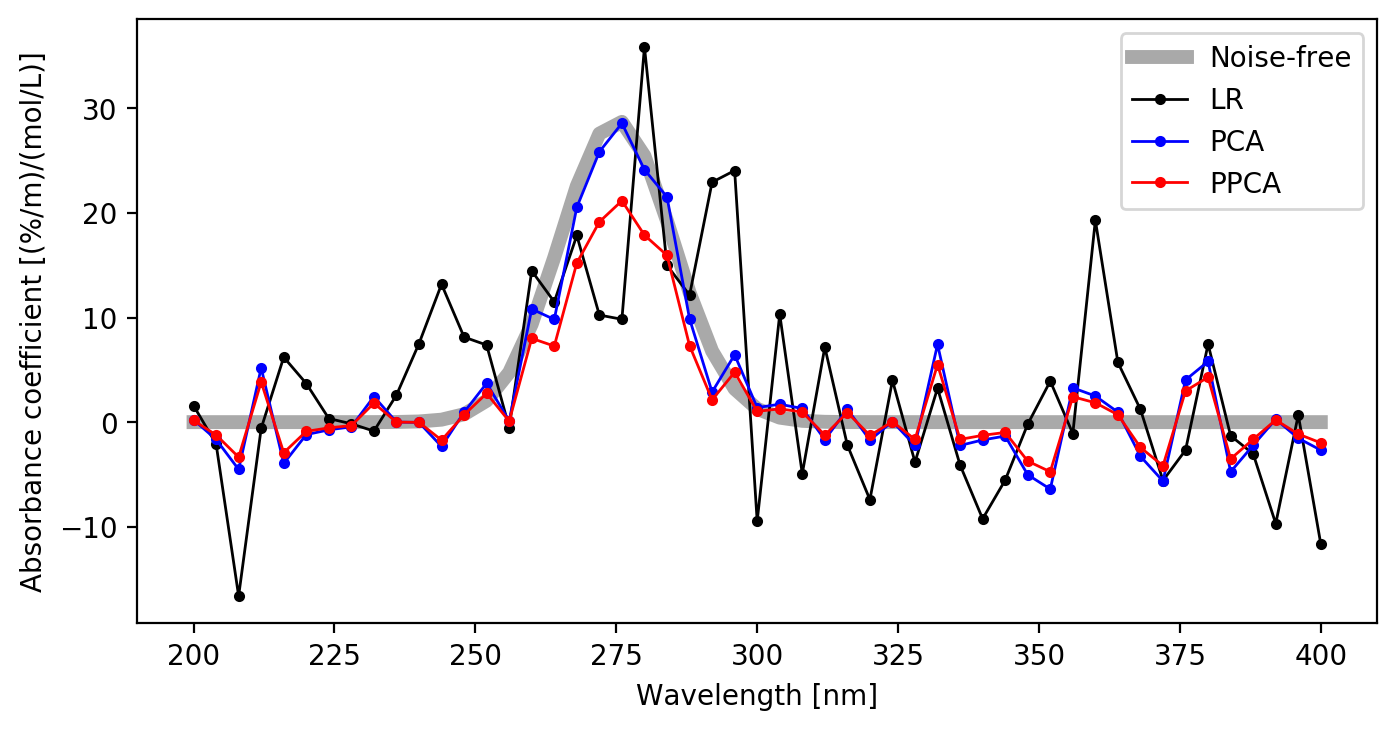

In [4]:
Xtil_cal0  = np.concatenate([np.ones(M_cal)[:,None],Xtil_cal],axis=1)
Xtil_test0 = np.concatenate([np.ones(M_test)[:,None],Xtil_test],axis=1)

# LR model
betahat_LR = np.dot(np.linalg.pinv(Xtil_cal0),ytil_cal)

# PCA and PPCA model
Z = np.concatenate([Xtil_cal,ytil_cal[:,None]],axis=1)
zm = np.mean(Z,axis=0)
Zcs = Z-zm #np.divide(,[sigma_x,sigma_y])
[U,S,V] = np.linalg.svd(Zcs, full_matrices=True, compute_uv=True, hermitian=False)

jy = L
jx = range(L)
betahat_PCA_z = np.dot( np.linalg.pinv(V[:K,jx]), V[:K,jy])
betahat_PCA_z

# PPCA model
S[K:] = np.mean(S[K:])
Sigmahat_PPCA = np.dot( np.dot(V.T,(np.diag(S))**2/M_cal),V )
Sigmahat_PPCA_y = Sigmahat_PPCA[jy,jy]
Sigmahat_PPCA_x = Sigmahat_PPCA[jx,:][:,jx]
Sigmahat_PPCA_xy = Sigmahat_PPCA[jx,jy]
betahat_PPCA_z = np.dot(np.linalg.inv(Sigmahat_PPCA_x),Sigmahat_PPCA_xy)

fig,axs = plt.subplots(nrows=1, ncols=1,figsize=[8,4],dpi=200, sharex='col', sharey='row') 
ax = axs #[0,0]
ax.plot(x, beta[1:]*L,'-',label='Noise-free',lw=5,color='darkgrey')
ax.plot(x, betahat_LR[1:]*L,'k.-',lw=1,label='LR')
ax.plot(x, betahat_PCA_z*L,'b.-',lw=1,label='PCA')
ax.plot(x, betahat_PPCA_z*L,'r.-',lw=1,label='PPCA')
ax.set_xlabel('Wavelength [nm]' )
ax.set_ylabel('Absorbance coefficient [(%/m)/(mol/L)]' )
ax.legend();

### 2.2.2. Model Testing

The three models are tested for soft-sensing now. We assume to know the measured spectrum (input) and predict the compound concentration (output) with every model. The next plots show the prediction errors (difference between prediction and true value) and the prediction residuals (difference between prediction and measured value) as function of the predicted value.  These are obtained with independent test data. The corresponding correlation coefficients are shown as well. The LR- and PCA-based prediction errors and residuals show quite some correlation with the predicted values. This suggests that the LR- and PCA-based predictions should not be trusted. In contrast, the prediction errors and residuals obtained with PPCA exhibit very small correlation to the predictions. The spread of the errors and residuals is narrower also. Clearly, PPCA offers the best available predictions in this case.

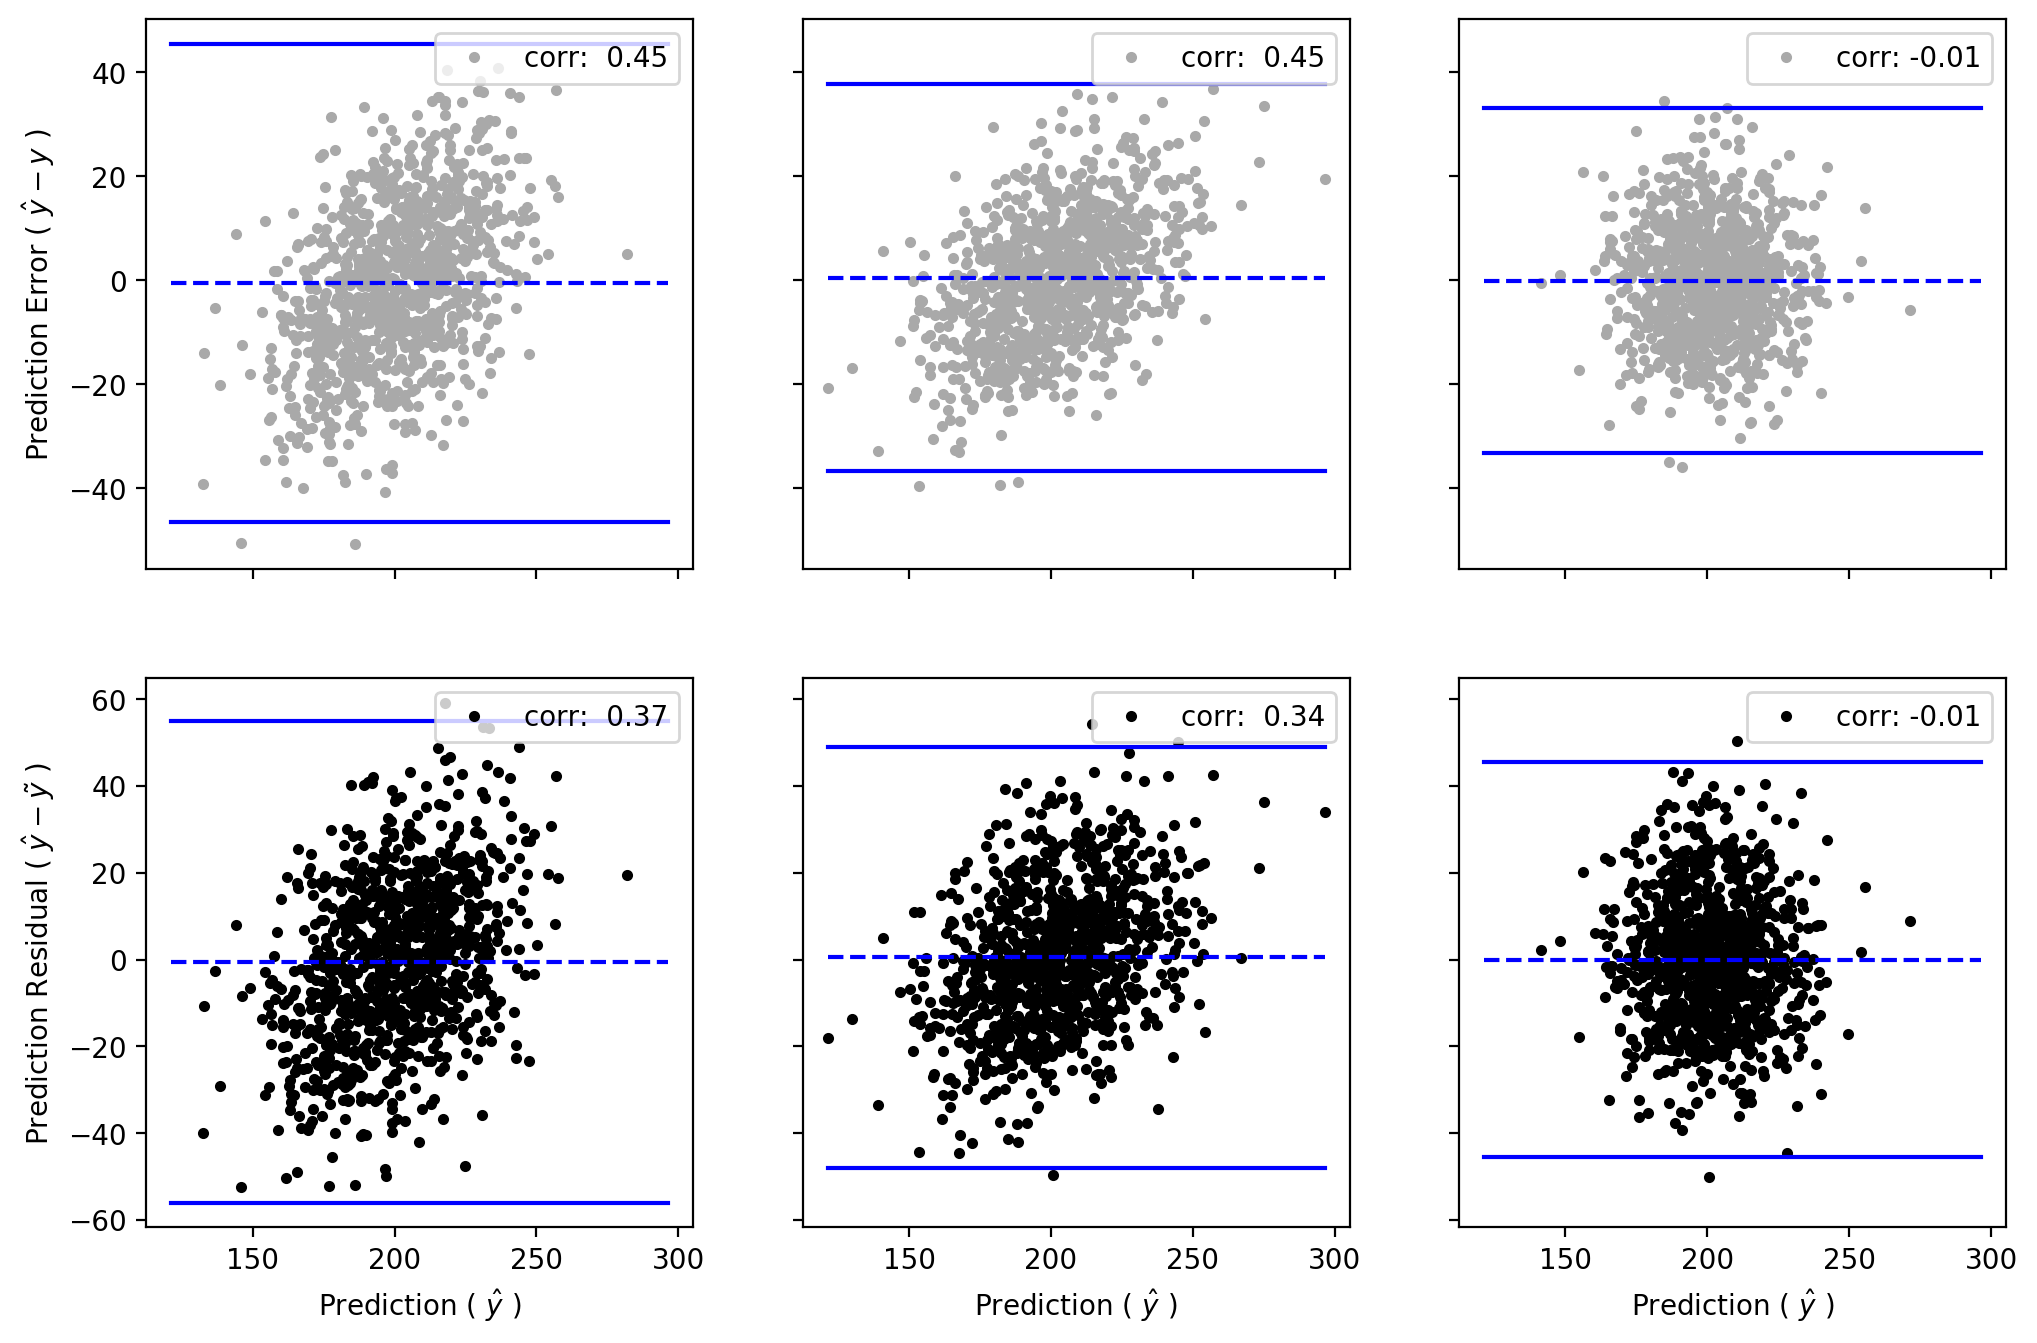

In [5]:
# 3.1 Linear model
yhat_LR_test = np.dot(Xtil_test0,betahat_LR)
e_LR_test = yhat_LR_test-y_test
r_LR_test = yhat_LR_test-ytil_test
e_LR_test_mn = np.mean(e_LR_test)
e_LR_test_sd = np.std(e_LR_test)
r_LR_test_mn = np.mean(r_LR_test)
r_LR_test_sd = np.std(r_LR_test)
ecorr_LR_test = pearsonr(yhat_LR_test,e_LR_test)[0]
rcorr_LR_test = pearsonr(yhat_LR_test,r_LR_test)[0]

# 3.2 PCA model
Zx = Xtil_test
Zcs = np.divide(Zx-zm[jx],1)
yhat_PCA_test = np.dot(Zcs,betahat_PCA_z)*1+zm[jy]
e_PCA_test = yhat_PCA_test-y_test
r_PCA_test = yhat_PCA_test-ytil_test
e_PCA_test_mn = np.mean(e_PCA_test)
e_PCA_test_sd = np.std(e_PCA_test)
r_PCA_test_mn = np.mean(r_PCA_test)
r_PCA_test_sd = np.std(r_PCA_test)
ecorr_PCA_test = pearsonr(yhat_PCA_test,e_PCA_test)[0]
rcorr_PCA_test = pearsonr(yhat_PCA_test,r_PCA_test)[0]

# 3.3 PPCA model
zhat_PPCA_test = np.dot(np.dot(Zcs[:,jx],np.linalg.inv(Sigmahat_PPCA_x)),Sigmahat_PPCA_xy)
yhat_PPCA_test = zhat_PPCA_test*1+zm[jy]
e_PPCA_test = yhat_PPCA_test-y_test
r_PPCA_test = yhat_PPCA_test-ytil_test
e_PPCA_test_mn = np.mean(e_PPCA_test)
e_PPCA_test_sd = np.std(e_PPCA_test)
r_PPCA_test_mn = np.mean(r_PPCA_test)
r_PPCA_test_sd = np.std(r_PPCA_test)
ecorr_PPCA_test = pearsonr(yhat_PPCA_test,e_PPCA_test)[0]
rcorr_PPCA_test = pearsonr(yhat_PPCA_test,r_PPCA_test)[0]

ymin = np.min([yhat_LR_test,yhat_PCA_test,yhat_PPCA_test])
ymax = np.max([yhat_LR_test,yhat_PCA_test,yhat_PPCA_test])

fig,axs = plt.subplots(nrows=2, ncols=3,figsize=[12,8],dpi=200, sharex='col', sharey='row') #
ax = axs[0,0]
ax.plot(yhat_LR_test,e_LR_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_LR_test))
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2)+3*e_LR_test_sd,'b-')
ax.plot([ymin,ymax],+e_LR_test_mn*np.ones(2)-3*e_LR_test_sd,'b-')
ax.set_ylabel('Prediction Error ( $\^y-y$ )');
ax.legend(loc=1)
ax = axs[1,0]
ax.plot(yhat_LR_test,r_LR_test,'k.',label='corr:{:6.2f}'.format(rcorr_LR_test))
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2)+3*r_LR_test_sd,'b-')
ax.plot([ymin,ymax],+r_LR_test_mn*np.ones(2)-3*r_LR_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.set_ylabel('Prediction Residual ( $\^y-\~y$ )');
ax.legend(loc=1)

ax = axs[0,1]
ax.plot(yhat_PCA_test,e_PCA_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_PCA_test))
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2)+3*e_PCA_test_sd,'b-')
ax.plot([ymin,ymax],+e_PCA_test_mn*np.ones(2)-3*e_PCA_test_sd,'b-')
ax.legend(loc=1)
ax = axs[1,1]
ax.plot(yhat_PCA_test,r_PCA_test,'k.',label='corr:{:6.2f}'.format(rcorr_PCA_test))
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2)+3*r_PCA_test_sd,'b-')
ax.plot([ymin,ymax],+r_PCA_test_mn*np.ones(2)-3*r_PCA_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.legend(loc=1)

ax = axs[0,2]
ax.plot(yhat_PPCA_test,e_PPCA_test,'.',color='darkgrey',label='corr:{:6.2f}'.format(ecorr_PPCA_test))
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2)+3*e_PPCA_test_sd,'b-')
ax.plot([ymin,ymax],+e_PPCA_test_mn*np.ones(2)-3*e_PPCA_test_sd,'b-')
ax.legend(loc=1)
ax = axs[1,2]
ax.plot(yhat_PPCA_test,r_PPCA_test,'k.',label='corr:{:6.2f}'.format(rcorr_PPCA_test))
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2),'b--')
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2)+3*r_PPCA_test_sd,'b-')
ax.plot([ymin,ymax],+r_PPCA_test_mn*np.ones(2)-3*r_PPCA_test_sd,'b-')
ax.set_xlabel('Prediction ( $\^y$ )');
ax.legend(loc=1)

plt.show();


## 2.3. Take home message

PPCA-based soft-sensors deliver optimal prediction under specific conditions, which are:

* The joint distribution of the inputs and outputs is a multivariate normal distribution

* Both inputs and outputs exhibit measurement errors that are normally distributed 

* The standard deviation of the measurement errors are known or estimated precisely and are used to scale both inputs and outputs

* The distribution of the generated data during model use is the same as the distribution during model calibration

## Code availability

You can find this post as a notebook on [GitLab](https://gitlab.com/krisvillez/software-sensors).

## Literature

[1] Russo, S, Li, G, Villez, K (2019). Automated model selection in principal component analysis: A new approach based on the cross-validated ignorance score. Ind Eng Chem Res, 58(30), 13448-13468. [[preprint]](https://arxiv.org/abs/1902.03293) [[publisher]](https://pubs.acs.org/doi/10.1021/acs.iecr.9b00642)

[2] [https://en.wikipedia.org/wiki/Missing_data](https://en.wikipedia.org/wiki/Missing_data)

[3] Wentzell, P. D., Andrews, D. T., Hamilton, D. C., Faber, K., & Kowalski, B. R. (1997). Maximum likelihood principal component analysis. Journal of Chemometrics, 11(4), 339-366. [[publisher]](https://doi.org/10.1002/(SICI)1099-128X(199707)11:4%3C339::AID-CEM476%3E3.0.CO;2-L)

[4] Schuermans, M., Markovsky, I., Wentzell, P. D., & Van Huffel, S. (2005). On the equivalence between total least squares and maximum likelihood PCA. Analytica Chimica Acta, 544(1-2), 254-267. [[publisher]](https://doi.org/10.1016/j.aca.2004.12.059)

[5] Nelson, P. R., Taylor, P. A., & MacGregor, J. F. (1996). Missing data methods in PCA and PLS: Score calculations with incomplete observations. Chemometrics and intelligent laboratory systems, 35(1), 45-65. [[publisher]](https://doi.org/10.1016/S0169-7439(96)00007-X)

[6] Folch-Fortuny, A., Arteaga, F., & Ferrer, A. (2015). PCA model building with missing data: New proposals and a comparative study. Chemometrics and Intelligent Laboratory Systems, 146, 77-88. [[publisher]](https://doi.org/10.1016/j.chemolab.2015.05.006)

[7] Tipping, M. E., & Bishop, C. M. (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 61(3), 611-622. [[publisher]](https://doi.org/10.1111/1467-9868.00196)

[8] Roweis, S. T. (1998). EM algorithms for PCA and SPCA. In: Advances in Neural Information Processing Systems (pp. 626-632). [[publisher]](http://papers.nips.cc/paper/1398-em-algorithms-for-pca-and-spca.pdf)